In [1]:
def negative_class_edit(Y):
    Ytemp = Y
    for i,cl in enumerate(Ytemp):
        if cl == 0:
           Ytemp[i] = -1
    return Ytemp

In [23]:
import numpy as np
import matplotlib.pyplot as plot
import mltools as ml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression,Perceptron
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier

In [3]:
#change path if your notebook is not in the same directory as your data files are
#this trains on the entire data set.

X = np.genfromtxt("Training/training_data_IPCA.txt",delimiter=None)
Y = np.genfromtxt("Training/train_Y.txt",delimiter=None)
train_data = X
train_Y = negative_class_edit(Y)


In [4]:
Xtest = np.genfromtxt("Test/test_data_IPCA.txt",delimiter=None)
Validation_X = np.genfromtxt("Validation/validation_data_IPCA.txt",delimiter=None)
Validation_Y = np.genfromtxt("Validation/validation_Y.txt")
Validation_Y = negative_class_edit(Validation_Y)

In [35]:
#change number of boosts if you want more or less learners
class AdaBoost:
      def __init__(self,nboosts):
          self.nboosts = nboosts
          self.learner = [None] * nboosts
          self.mTest = train_data.shape[0]
          #print train_data.shape
          self.alpha = [1] * nboosts
          self.weights = [1.0]*self.mTest
          for i in range(len(self.weights)):
              self.weights[i] /= self.mTest
          for i in range(nboosts):
              print i
              self.learner[i] = DecisionTreeClassifier(criterion='entropy',min_samples_split= 30)
              self.learner[i].fit(train_data,train_Y,sample_weight = self.weights)
              Yhat = self.learner[i].predict(train_data)
              e = np.dot(self.weights,train_Y != Yhat)
              self.alpha[i] = .5 * np.log((1.0-e)/e)
              self.weights *=np.exp(-self.alpha[i] * train_Y * Yhat)
              self.weights /= self.weights.sum()
      def predictions(self,X,learners):
        mTests = X.shape[0]
        if (self.nboosts < learners):
            print 'err'
            return
        predict = np.zeros((mTests,))
        for i in range(learners):
            predict += self.alpha[i] * self.learner[i].predict(X)
        predict = np.sign(predict)
        return predict
      def predict_soft(self,X,learners):
            #learners cannot be greater than self.mtest
        if self.nboosts < learners:
           print 'err'
           return
        classes = 2
        prob = np.zeros((X.shape[0],2))
        for i in range(learners):
            prob += self.alpha[i] * self.learner[i].predict_proba(X)
        prob /= sum(self.alpha)
        prob = np.exp(prob)
        normalizer = prob.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        prob /= normalizer
        return prob
    
    
    

In [20]:
#np.savetxt("alpha.txt", alpha)


In [36]:
booster = AdaBoost(20)



In [39]:

training_auc = []
validation_auc = []
for i in range(1,21):
    print i
    training_predictions = booster.predictions(train_data,i)
    validation_predictions = booster.predictions(Validation_X,i)
    training_auc.append(roc_auc_score(train_Y,training_predictions))
    validation_auc.append(roc_auc_score(Validation_Y,validation_predictions))

    
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


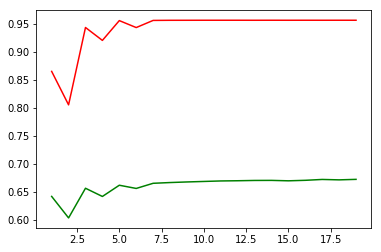

In [38]:
plot.plot(range(1,20), training_auc, color = 'red')
plot.plot(range(1,20),validation_auc,color='green')

plot.show()
    

In [19]:
#predict_soft(train_data)

[[ 0.49974657  0.50025343]
 [ 0.51210432  0.48789568]
 [ 0.48647189  0.51352811]
 ..., 
 [ 0.5111964   0.4888036 ]
 [ 0.49252147  0.50747853]
 [ 0.51014152  0.48985848]]


In [40]:
Yte = np.vstack((np.arange(Xtest.shape[0]), booster.predict_soft(Xtest,booster.nboosts)[:,1])).T
#print Yte
np.savetxt('Y_submit.txt', Yte, '%d, %.2f', header='ID,Prob1', comments='', delimiter=',')